## Kernel Galerkin

In [2]:
import sys
import os

project_root = os.path.abspath("..")  # If notebooks is one folder above src
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from src.eigensolver.galerkin.galerkin_eigensolver import GalerkinSolver
from src.energy.quadratic import QuadraticEnergy
from src.energy.gaussian_mixture import GaussianMixture
from src.eigensolver.galerkin.kernel_basis import KernelBasis
from src.eigensolver.galerkin.constant_basis import ConstantBasis
from src.eigensolver.galerkin.orthogonal_basis import OrthogonalBasis
from src.eigensolver.galerkin.kernels.gaussian_kernel import GaussianKernel
from src.eigensolver.galerkin.kernels.polynomial_kernel import PolynomialKernel
from src.metrics.eigen_evaluator import EigenEvaluator

In [4]:
def kernel_experiment(experiment_params, energy, kernel_class = GaussianKernel):
    kernel_params = experiment_params['kernel_params']
    solver_params = experiment_params['solver_params']

    np.random.seed(42)
    dim = kernel_params['dim']
    x = energy.exact_sample((200000,))

    kernel = kernel_class(kernel_params)

    p = kernel_params['p']
    L_reg = solver_params['L_reg']
    k = solver_params['k']
    
    basis_points = energy.exact_sample((p,))
    basis = KernelBasis(kernel, basis_points)
    basis = ConstantBasis(basis)

    solver = GalerkinSolver(energy, x, solver_params)

    solver = solver.fit(basis,k=min(p-1,k),L_reg=L_reg)

    return x, solver

In [5]:
def plot_eigenfunctions(x,solver, k):
    l = 4
    fig, ax = plt.subplots(k//l,l,figsize=(20,k*1.2))
    fx = solver.predict(x)
    Lfx = solver.predict_Lf(x)
    for m in range(k):
        ax[m // l, m % l].hist2d(fx[:,m],Lfx[:,m],bins=50,cmap='viridis')
        ax[m // l, m % l].plot(fx[:,m],fx[:,m]*solver.eigvals[m],color='white')
        ax[m // l, m % l].set_xlabel("f(x)")
        ax[m // l, m % l].set_ylabel("Lf(x)")
        ax[m // l, m % l].set_title(f'Eigenvalue m = {m}, $\\lambda$ = {solver.eigvals[m]:.3f}')

In [5]:
metrics = ['eigen_error','orth_error','eigen_cost', 'eigenvalue_mse','eigenfunc_mse', "fitted_eigenvalue_mse"]
experiment_params = {
    'kernel_params': {
        'dim': 5,
        'p': 100,
        'scale': 5.0,
        'order': 3
    },
    'solver_params': {
        'regularizer': 0.0,
        'L_reg': 1e-6,
        'verbose': False,
        'k': 6
    }
}

energy = QuadraticEnergy(np.eye(experiment_params['kernel_params']['dim']))

x, solver = kernel_experiment(experiment_params, energy, PolynomialKernel)

if solver is None:
    print('Error')
else:
    evaluator = EigenEvaluator(energy)
    x_eval = energy.exact_sample((10000,))

    out = evaluator.evaluate_metrics(solver, x_eval, metrics, k = experiment_params['solver_params']['k'])
    for metric in metrics:
        print(f'{metric}: {out[metric]}')

eigen_error: [6.32018278e-05 1.28202361e-02 1.68085205e-02 1.58838596e-02
 1.38991126e-02 1.47542641e-02]
orth_error: [ 4.40254261e-14  5.73415030e-04 -2.89487487e-04 -1.15361346e-04
  2.53173292e-05]
eigen_cost: [5.23129026e-05 9.53335062e+03 9.90011487e+03 1.00034998e+04
 1.00872380e+04 1.01783969e+04]
eigenvalue_mse: [6.29294811e-15 2.13215634e-03 9.20736774e-05 4.77430339e-07
 8.40736118e-05 3.33628868e-04]
eigenfunc_mse: [1.78152903e-09 6.90310246e-03 5.88204099e-03 8.00706760e-03
 4.98293722e-03 4.15067914e-03]
fitted_eigenvalue_mse: [6.31805779e-05 8.88347894e-06 1.82301801e-03 3.09682810e-03
 4.36815420e-05 1.50669906e-03]


/home/lclaeys/eigenfunction-solver/src/metrics/eigen_evaluator.py:157: RuntimeWarning: divide by zero encountered in divide
  ax[i].plot(t,rotated_Lfx[:,i]/eigvals[i],lw=2,color='red',label='Lfx/lambda')


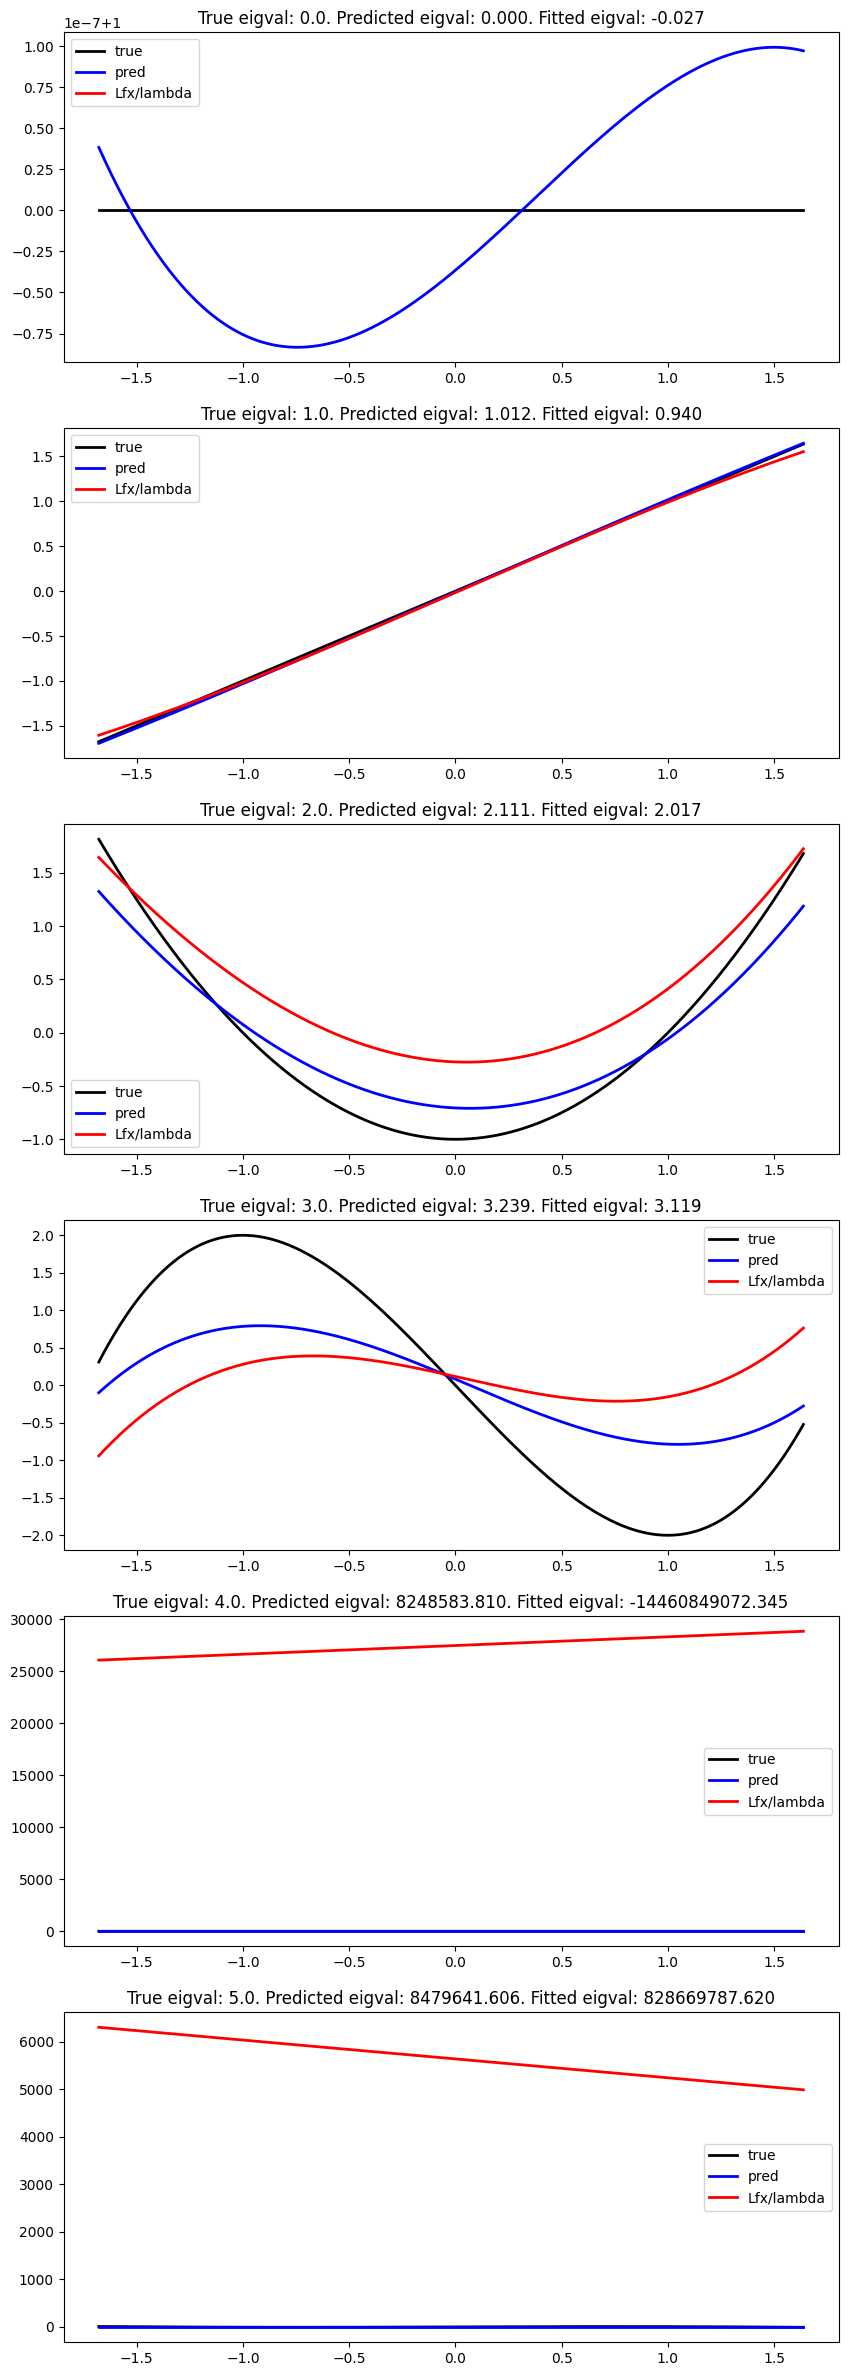

In [16]:
_ = evaluator.plot_eigfuncs_exact(solver,x_eval,6)

## Gaussian Mixture

In [ ]:
metrics = ['eigen_error','orth_error','eigen_cost', 'fitted_eigen_error']
experiment_params = {
    'kernel_params': {
        'dim': 20,
        'p': 300,
        'scale': 10.0,
        'order': 3
    },
    'solver_params': {
        'regularizer': 0.0,
        'L_reg': 1e-6,
        'verbose': False,
        'k': 200
    }
}

means = np.array([np.zeros(20),np.zeros(20)])
covs = np.array([np.diag(0.5+np.random.random(20)),np.diag(0.5+np.random.random(20))])

# means = np.array([[0,0],[0,0]])
# covs = np.array([[[5,0],[0,1]], [[1,0],[0,5]]])

#means = np.array([[0], [5]])
#covs = np.array([[[1]], [[1]]])
w = np.array([0.5,0.5])

energy = GaussianMixture(w,means,covs)
x, solver = kernel_experiment(experiment_params, energy, GaussianKernel)

if solver is None:
    print('Error')
else:
    evaluator = EigenEvaluator(energy)
    x_eval = energy.exact_sample((10000,))

    out = evaluator.evaluate_metrics(solver, x_eval, metrics, k = experiment_params['solver_params']['k'])
    for metric in metrics:
        print(f'{metric}: {out[metric]}')

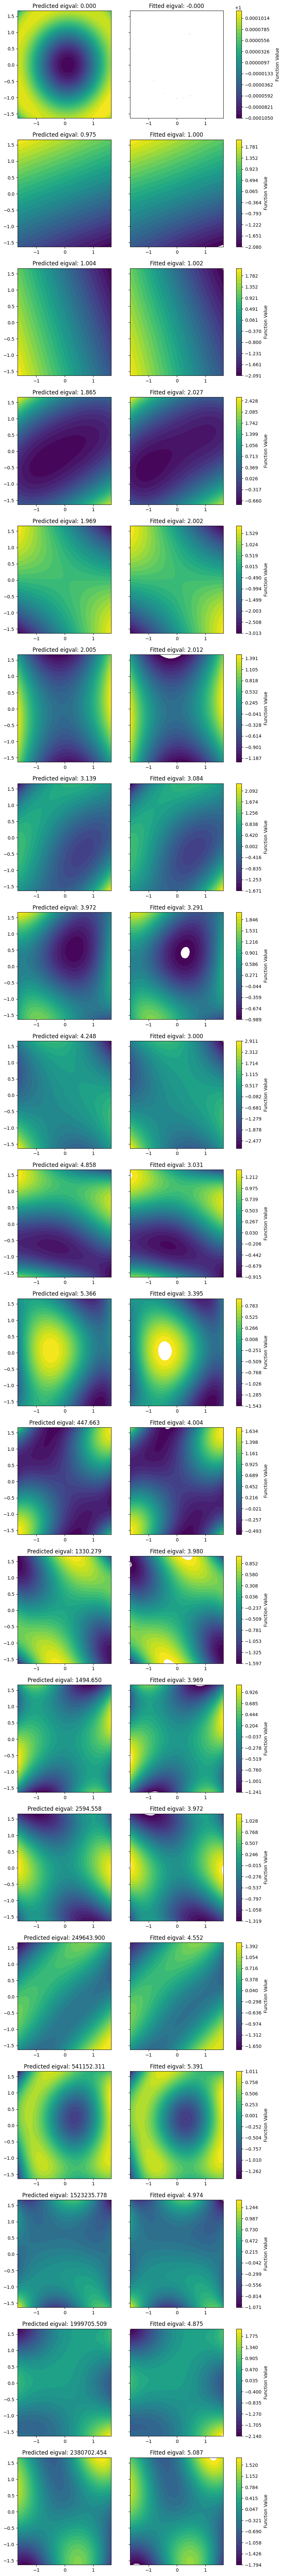

In [246]:
_ = evaluator.plot_eigfuncs(solver,x_eval,20)

In [7]:
# reconstruct |x|^2

x = energy.exact_sample((100000,))
k = 200
eigfuncs = solver.predict(x)
weights = np.array([0]*19 + [1])
func = lambda x: 1/2*np.sum(x**2,axis=1)
fx = func(x)
Lfx = np.sum(energy.grad(x) * x,axis=1) - energy.dim

In [8]:
inner_prods = np.sum(fx[:,None]*eigfuncs,axis=0)/x.shape[0]

In [9]:
errs = []
L_errs = []

for i in range(1,k+1):
    errs.append(1-np.mean((fx - inner_prods[:i]@(eigfuncs[:,:i]).T)**2)/np.mean((func(x) - np.mean(func(x)))**2))
    L_errs.append(1-np.mean((Lfx - (solver.fitted_eigvals[:i]*inner_prods[:i])@(eigfuncs[:,:i]).T)**2)/np.mean(Lfx**2))

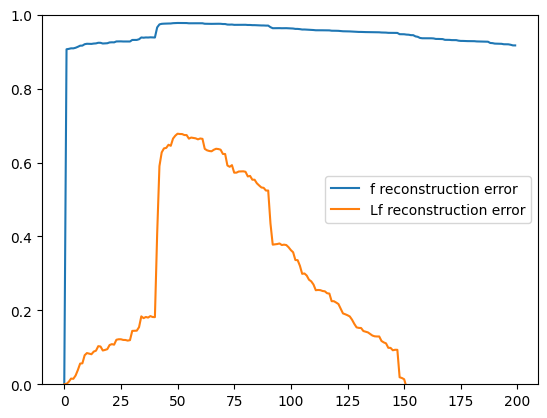

In [11]:
plt.plot(errs, label = 'f reconstruction error')
plt.plot(L_errs, label = 'Lf reconstruction error')

plt.ylim(0,1)
plt.legend()

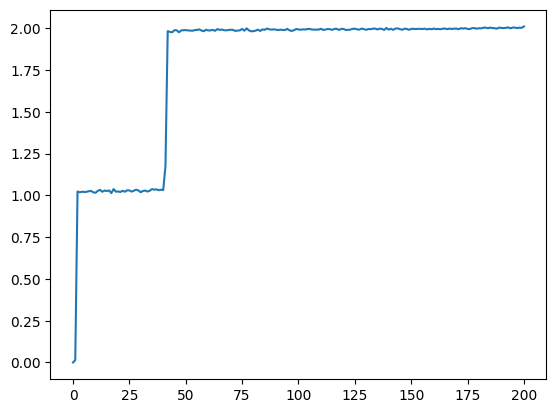

In [347]:
plt.plot(solver.fitted_eigvals, label = 'eigvals')

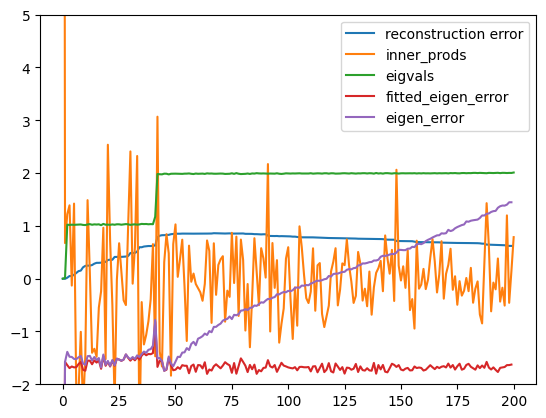

In [348]:
plt.plot(errs, label = 'reconstruction error')
plt.plot(inner_prods, label = 'inner_prods')
plt.plot(solver.fitted_eigvals, label = 'eigvals')
plt.plot(np.log10(out['fitted_eigen_error']),label = 'fitted_eigen_error')
plt.plot(np.log10(out['eigen_error']),label = 'eigen_error')

plt.ylim(-2,5)
plt.legend()

In [149]:
np.mean((func(x) - inner_prods@eigfuncs.T)**2)

np.float64(0.4760264414619271)

In [150]:
np.mean((func(x) - np.mean(func(x)))**2)

np.float64(1.219519479477328)

In [151]:
1-np.mean((func(x) - inner_prods@eigfuncs.T)**2)/np.mean((func(x) - np.mean(func(x)))**2)

np.float64(0.6096606495650676)

### Hyperparameter experiment

In [ ]:

for kernel_scale in tqdm(kernel_scales):
    for p in ps:
        #x, solver = polynomial_kernel_experiment(dim, p, kernel_scale, kernel_order=kernel_order)
        x, solver = gaussian_kernel_experiment(dim, p, kernel_scale)
        
        if solver is not None:
            eigen_errs.append(eigen_error(x,solver,k))
            orth_errs.append(orth_error(x,solver,k))
            L_prod_errs.append(L_prod_error(x,solver,k))
        else:
            eigen_errs.append(np.nan)
            orth_errs.append(np.nan)
            L_prod_errs.append(np.nan)

eigen_errs = np.array(eigen_errs).reshape((len(kernel_scales),len(ps)))
orth_errs = np.array(orth_errs).reshape((len(kernel_scales),len(ps)))
L_prod_errs = np.array(L_prod_errs).reshape((len(kernel_scales),len(ps)))

Text(0, 0.5, 'kernel scale')

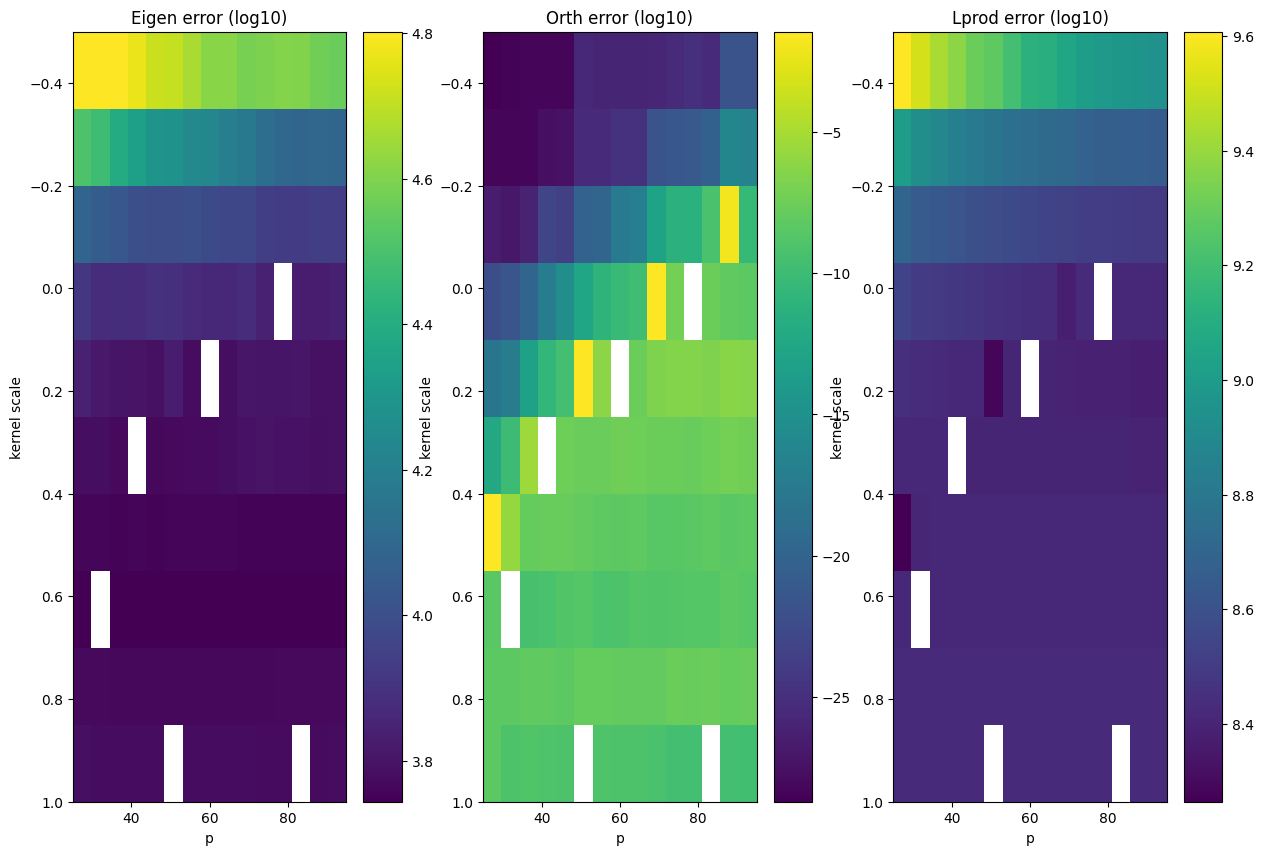

In [31]:
fig, ax = plt.subplots(1,3,figsize=(15,10))

cax = ax[0].imshow(np.log10(eigen_errs),extent=(ps[0],ps[-1],np.log10(kernel_scales[-1]),np.log10(kernel_scales[0])),aspect='auto')
cbar = fig.colorbar(cax, ax=ax[0],shrink=1)
ax[0].set_title('Eigen error (log10)')

cax = ax[1].imshow(np.log10(orth_errs),extent=(ps[0],ps[-1],np.log10(kernel_scales[-1]),np.log10(kernel_scales[0])),aspect='auto')
cbar = fig.colorbar(cax, ax=ax[1],shrink=1)
ax[1].set_title('Orth error (log10)')

cax = ax[2].imshow(np.log10(L_prod_errs),extent=(ps[0],ps[-1],np.log10(kernel_scales[-1]),np.log10(kernel_scales[0])),aspect='auto')
cbar = fig.colorbar(cax, ax=ax[2],shrink=1)
ax[2].set_title('Lprod error (log10)')

ax[0].set_xlabel('p')
ax[0].set_ylabel('kernel scale')
ax[1].set_xlabel('p')
ax[1].set_ylabel('kernel scale')
ax[2].set_xlabel('p')
ax[2].set_ylabel('kernel scale')

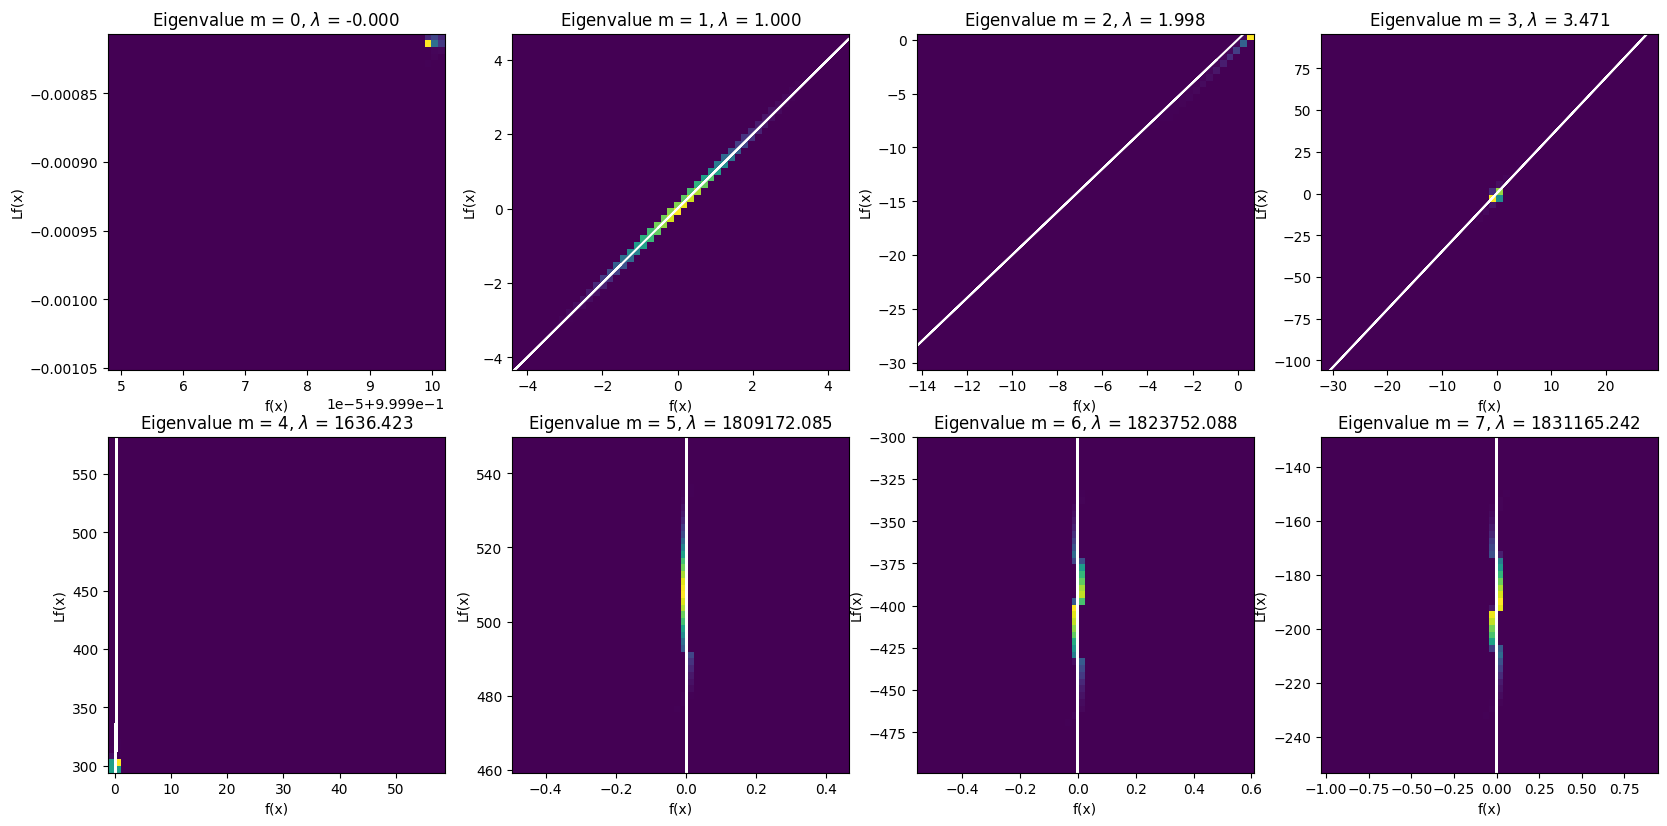

In [64]:
plot_eigenfunctions(x,solver,8)

In [12]:
grad = np.random.standard_normal((1000,100,10))

In [8]:
from itertools import product
import numpy as np

arrays = [np.array([1, 2]), np.array([3, 4]), [5]]
cartesian_product = np.array(list(product(*arrays)))

In [1]:
a = {'b': 1}
c = {'d': 4}

In [8]:
import numpy as np

In [9]:
class TestClass():
    def __init__(self, rng):
        self.rng = np.random.default_rng(rng)

    def random_number(self):
        print(self.rng.random(1))

In [16]:
rng = np.random.default_rng(32)

In [12]:
means = np.array([[0,0],[1,0]])
covs = np.array([np.eye(2),np.eye(2)])
w = np.array([0.5,0.5])

energy = GaussianMixture(w,means,covs)

AttributeError: 'numpy.ndarray' object has no attribute 'dim'

In [7]:
sample = np.random.multivariate_normal(np.zeros(2), A, size = 10)
        

In [8]:
sample

array([[-1.03591711e+00, -4.38469364e-01],
       [-1.20226348e+00, -5.02518805e-01],
       [-5.90221913e-01, -6.32865982e-01],
       [-1.03081200e-01, -8.50193181e-01],
       [-1.50020486e-01, -3.26154397e-04],
       [ 2.65191361e-01,  9.31788362e-02],
       [ 9.81780193e-01,  2.54230429e-01],
       [ 1.67686907e+00,  3.78149627e-02],
       [-6.33384107e-01, -4.11349989e-01],
       [-1.98442068e-02, -2.65256227e-01]])